<a href="https://colab.research.google.com/github/JungWoo-Chae/GCN_Elliptic_dataset/blob/main/Elliptic_dataset_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Fraud Detection System with GCN

## Pytorch Geometric Environment Setting

In [ ]:
# Install required packages.
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

     |████████████████████████████████| 11.9MB 45.7MB/s 
     |████████████████████████████████| 24.3MB 1.2MB/s 
     |████████████████████████████████| 235kB 14.2MB/s 
     |████████████████████████████████| 2.2MB 42.0MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 


## Library Import

In [ ]:
import numpy as np
import networkx as nx
import os
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding
from torch.nn import Parameter
from torch_geometric.data import Data,DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import to_undirected

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Please insert Kaggle username and kaggle key**

In [ ]:
os.environ['KAGGLE_USERNAME'] = "@@@@@@@@@" # username from the json file
os.environ['KAGGLE_KEY'] = "####################" # key from the json file
!kaggle datasets download -d ellipticco/elliptic-data-set
!unzip elliptic-data-set.zip
!mkdir elliptic_bitcoin_dataset_cont

 94% 137M/146M [00:01<00:00, 96.8MB/s]
100% 146M/146M [00:01<00:00, 104MB/s] 
Archive:  elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


## Data Preparation

In [ ]:
# Load Dataframe
df_edge = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_class = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_features = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv',header=None)

# Setting Column name
df_features.columns = ['id', 'time step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]

print('Number of edges: {}'.format(len(df_edge)))

Number of edges: 234355


## Get Node Index

In [ ]:
all_nodes = list(set(df_edge['txId1']).union(set(df_edge['txId2'])).union(set(df_class['txId'])).union(set(df_features['id'])))
nodes_df = pd.DataFrame(all_nodes,columns=['id']).reset_index()

print('Number of nodes: {}'.format(len(nodes_df)))

Number of nodes: 203769


## Fix id index

In [ ]:
df_edge = df_edge.join(nodes_df.rename(columns={'id':'txId1'}).set_index('txId1'),on='txId1',how='inner') \
       .join(nodes_df.rename(columns={'id':'txId2'}).set_index('txId2'),on='txId2',how='inner',rsuffix='2') \
       .drop(columns=['txId1','txId2']) \
       .rename(columns={'index':'txId1','index2':'txId2'})
df_edge.head()

,txId1,txId2
0,153796,56598
1,56486,137561
3575,153260,137561
1387,153676,137561
6890,170223,137561


In [ ]:
df_class = df_class.join(nodes_df.rename(columns={'id':'txId'}).set_index('txId'),on='txId',how='inner') \
        .drop(columns=['txId']).rename(columns={'index':'txId'})[['txId','class']]
df_class.head()

,txId,class
0,153796,unknown
1,56598,unknown
2,56486,unknown
3,137561,2
4,161325,unknown


In [ ]:
df_features = df_features.join(nodes_df.set_index('id'),on='id',how='inner') \
        .drop(columns=['id']).rename(columns={'index':'id'})
df_features = df_features [ ['id']+list(df_features.drop(columns=['id']).columns) ]
df_features.head()

,id,time step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,153796,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,-0.164402,-0.028741,-0.035391,-0.042955,-0.013282,-0.057195,-0.169609,-0.171154,-0.174473,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.120950,-0.199145,-0.187993,-0.212948,1.064205,1.063787,-1.373782,-1.354735,-0.297975,-1.403698,1.342003,1.340733,-0.171601,-0.458162,-0.423588,-0.440883,-1.015963,-1.016230,-0.968903,-0.375715,0.759748,-0.768329,1.488113,1.487932,-0.216814,-0.605631,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,56598,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,56486,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,137561,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.07188

In [ ]:
df_edge_time = df_edge.join(df_features[['id','time step']].rename(columns={'id':'txId1'}).set_index('txId1'),on='txId1',how='left',rsuffix='1') \
.join(df_features[['id','time step']].rename(columns={'id':'txId2'}).set_index('txId2'),on='txId2',how='left',rsuffix='2')
df_edge_time['is_time_same'] = df_edge_time['time step'] == df_edge_time['time step2']
df_edge_time_fin = df_edge_time[['txId1','txId2','time step']].rename(columns={'txId1':'source','txId2':'target','time step':'time'})

## Create csv from Dataframe

In [ ]:
df_features.drop(columns=['time step']).to_csv('elliptic_bitcoin_dataset_cont/elliptic_txs_features.csv',index=False,header=None)
df_class.rename(columns={'txId':'nid','class':'label'})[['nid','label']].sort_values(by='nid').to_csv('elliptic_bitcoin_dataset_cont/elliptic_txs_classes.csv',index=False,header=None)
df_features[['id','time step']].rename(columns={'id':'nid','time step':'time'})[['nid','time']].sort_values(by='nid').to_csv('elliptic_bitcoin_dataset_cont/elliptic_txs_nodetime.csv',index=False,header=None)
df_edge_time_fin[['source','target','time']].to_csv('elliptic_bitcoin_dataset_cont/elliptic_txs_edgelist_timed.csv',index=False,header=None)

## Graph Preprocessing

In [ ]:
node_label = df_class.rename(columns={'txId':'nid','class':'label'})[['nid','label']].sort_values(by='nid').merge(df_features[['id','time step']].rename(columns={'id':'nid','time step':'time'}),on='nid',how='left')
node_label['label'] =  node_label['label'].apply(lambda x: '3'  if x =='unknown' else x).astype(int)-1
node_label.head()

,nid,label,time
0,0,1,17
1,1,2,13
2,2,1,10
3,3,2,27
4,4,2,31


In [ ]:
merged_nodes_df = node_label.merge(df_features.rename(columns={'id':'nid','time step':'time'}).drop(columns=['time']),on='nid',how='left')
merged_nodes_df.head()

,nid,label,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,0,1,17,0.218933,0.048298,-1.201369,2.054118,-0.063725,1.480381,2.981378,-0.157193,-0.101173,0.127603,-0.152598,-0.579930,-0.234867,-0.063200,-0.013282,5.608007,0.231778,-0.172908,0.751708,-0.243300,-0.243452,-0.139728,-0.146095,-0.078754,-0.154979,0.108984,-0.106066,-0.139730,-0.146090,-0.078753,-0.154979,0.109077,-0.105958,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.068457,-0.115668,-1.627558,-0.897054,0.906864,-0.015139,-0.188716,0.210674,-0.047722,-0.048171,-0.407359,-0.506459,-0.301754,-0.459161,0.183133,0.182748,-0.168742,-0.458162,-0.424672,-0.440022,0.143001,0.142525,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.135448,-0.068266,-0.131155,-0.011377,-0.120613,-0.119792
1,1,2,13,-0.167004,-0.178843,0.463609,-0.121970,-0.024025,-0.113002,-0.061584,-0.157528,-0.163428,-0.049707,-0.159838,-0.028741,-0.035391,-0.022711,-0.013282,-0.057378,-0.165010,-0.167148,-0.171545,-1.222435,-1.371460,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.097719,-0.127462,0.003143,0.002426,-0.122609,-0.197599,-0.186370,-0.212179,-1.074554,-1.160129,-0.649055,-0.706879,-0.278174,-0.690193,0.405208,0.761740,-0.165007,-0.391245,-0.363145,-0.358710,1.214012,1.301281,1.203124,0.669709,-0.564631,1.154192,1.313609,1.313439,-0.216814,3.519195,3.447003,2.346677,0.289197,0.851388,-0.098889,-0.049041,-0.030745,-0.068808,-1.194450,-0.940388
2,2,1,10,-0.172886,-0.184668,-1.201369,0.178180,-0.043875,0.222447,-0.061584,-0.163645,-0.169369,-0.049186,-0.165930,0.886679,1.189967,-0.042955,-0.013282,-0.056917,-0.171086,-0.172873,-0.176150,0.887058,0.884557,-0.139732,-0.148905,-0.080141,-0.155660,-0.185016,-0.815353,-0.139734,-0.148900,-0.080140,-0.155660,-0.184919,-0.815199,-0.024669,-0.031272,-0.023045,-0.026215,...,0.587033,0.127938,2.738218,1.164709,-0.124476,-0.200151,-0.188466,-0.214831,1.064205,1.063787,-0.830446,-0.877983,-0.300517,-0.872756,-0.975738,-0.975237,-0.168742,-0.458162,-0.424672,-0.440022,0.143001,0.142525,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.169472,-0.605631,-0.577099,-0.588384,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,3,2,27,-0.068066,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.056299,-0.063618,-0.049707,-0.058723,-0.028741,-0.035391,-0.042955,-0.013282,-0.046132,-0.064087,-0.050781,-0.052054,0.887058,0.884557,-0.139686,-0.148883,-0.080147,-0.155623,-0.010763,-0.012107,-0.139688,-0.148879,-0.080147,-0.155623,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.097719,-0.127462,0.003143,0.002426,-0.122845,-0.151191,-0.126676,-0.158223,1.064205,1.063787,0.196191,0.102624,-0.097194,0.174843,-0.975738,-0.975237,-0.163898,-0.456661,-0.424672,-0.437108,0.143001,0.142525,0.660117,-0.375715,-1.059868,0.142339,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241

In [ ]:
train_dataset=[]
test_dataset=[]
for i in range(49):
    nodes_df_tmp=merged_nodes_df[merged_nodes_df['time']==i+1].reset_index()
    nodes_df_tmp['index']=nodes_df_tmp.index
    df_edge_tmp = df_edge_time_fin.join(nodes_df_tmp.rename(columns={'nid':'source'})[['source','index']].set_index('source'),on='source',how='inner')\
        .join(nodes_df_tmp.rename(columns={'nid':'target'})[['target','index']].set_index('target'),on='target',how='inner',rsuffix='2') \
        .drop(columns=['source','target']) \
        .rename(columns={'index':'source','index2':'target'})
    x = torch.tensor(np.array(nodes_df_tmp.sort_values(by='index').drop(columns=['index','nid','label'])), dtype=torch.float)
    edge_index = torch.tensor(np.array(df_edge_tmp[['source','target']]).T, dtype=torch.long)
    edge_index = to_undirected(edge_index)
    mask = nodes_df_tmp['label']!=2
    y=torch.tensor(np.array(nodes_df_tmp['label']))

    if i+1<35:
        data = Data(x=x,edge_index=edge_index, train_mask=mask, y=y)
        train_dataset.append(data)
    else:
        data = Data(x=x,edge_index=edge_index, test_mask=mask, y=y)
        test_dataset.append(data)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, use_skip=False):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels[0])
        self.conv2 = GCNConv(hidden_channels[0], 2)
        self.use_skip = use_skip
        if self.use_skip:
            self.weight = nn.init.xavier_normal_(Parameter(torch.Tensor(num_node_features, 2)))


    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, data.edge_index)
        if self.use_skip:
            x = F.softmax(x+torch.matmul(data.x, self.weight), dim=-1)
        else:
            x = F.softmax(x, dim=-1)
        return x

    def embed(self, data):
        x = self.conv1(data.x, data.edge_index)
        return x

In [ ]:
model = GCN(num_node_features=data.num_node_features ,hidden_channels=[100])
model.to(device)

GCN(
  (conv1): GCNConv(166, 100)
  (conv2): GCNConv(100, 2)
)

## Train

#### Hyperparameter

In [ ]:
patience = 50
lr = 0.001
epoches = 1000

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.7,0.3]).to(device))


train_losses=[]
val_losses =[]
accuracies=[]
if1=[]
precisions=[]
recalls=[]
iterations=[]

for epoch in range(epoches):
    
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        _, pred = out[data.train_mask].max(dim=1)
        loss.backward()
        train_loss += loss.item() * data.num_graphs
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    

    if (epoch+1)%50==0:
        model.eval()
        ys, preds = [], []
        val_loss = 0
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out[data.test_mask], data.y[data.test_mask])
            val_loss += loss.item() * data.num_graphs
            _, pred = out[data.test_mask].max(dim=1)
            ys.append(data.y[data.test_mask].cpu())
            preds.append(pred.cpu())

        y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
        val_loss /= len(test_loader.dataset)
        f1 = f1_score(y, pred, average=None)
        mf1 = f1_score(y, pred, average='micro')
        precision = precision_score(y, pred, average=None)
        recall = recall_score(y, pred, average=None)

        iterations.append(epoch+1)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if1.append(f1[0])
        accuracies.append(mf1)
        precisions.append(precision[0])
        recalls.append(recall[0])

        print('Epoch: {:02d}, Train_Loss: {:.4f}, Val_Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Illicit f1: {:.4f}, F1: {:.4f}'.format(epoch+1, train_loss, val_loss, precision[0], recall[0], f1[0], mf1))

Epoch: 50, Train_Loss: 0.3916, Val_Loss: 0.4068, Precision: 0.5137, Recall: 0.6233, Illicit f1: 0.5632, F1: 0.9372
Epoch: 100, Train_Loss: 0.3762, Val_Loss: 0.3989, Precision: 0.8003, Recall: 0.5069, Illicit f1: 0.6207, F1: 0.9597
Epoch: 150, Train_Loss: 0.3679, Val_Loss: 0.4023, Precision: 0.8539, Recall: 0.4534, Illicit f1: 0.5923, F1: 0.9594
Epoch: 200, Train_Loss: 0.3623, Val_Loss: 0.4004, Precision: 0.8409, Recall: 0.4783, Illicit f1: 0.6098, F1: 0.9602
Epoch: 250, Train_Loss: 0.3587, Val_Loss: 0.3971, Precision: 0.7650, Recall: 0.5291, Illicit f1: 0.6255, F1: 0.9588
Epoch: 300, Train_Loss: 0.3561, Val_Loss: 0.3985, Precision: 0.7890, Recall: 0.5143, Illicit f1: 0.6227, F1: 0.9595
Epoch: 350, Train_Loss: 0.3553, Val_Loss: 0.4025, Precision: 0.8665, Recall: 0.4497, Illicit f1: 0.5921, F1: 0.9597
Epoch: 400, Train_Loss: 0.3533, Val_Loss: 0.3995, Precision: 0.8347, Recall: 0.4848, Illicit f1: 0.6133, F1: 0.9603
Epoch: 450, Train_Loss: 0.3523, Val_Loss: 0.3945, Precision: 0.7227, Reca

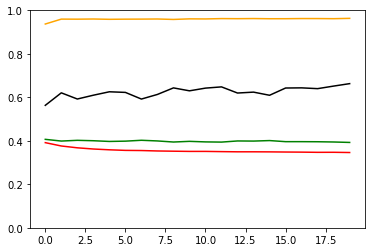

In [ ]:
a,b,c,d = train_losses, val_losses, if1, accuracies
plt.plot(np.array(a), 'r', label='Train loss')
plt.plot(np.array(b), 'g', label='Valid loss')
plt.plot(np.array(c), 'black', label='Illicit F1')
plt.plot(np.array(d), 'orange', label='F1')
plt.ylim([0,1.0])
plt.show()